In [25]:
!pip install transformers datasets scikit-learn -q

In [26]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report,confusion_matrix, ConfusionMatrixDisplay
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer,TextClassificationPipeline
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
from google.colab import files
uploaded = files.upload()  # Upload your drug_review_test.csv

Saving drug_review_test.csv to drug_review_test (1).csv


In [28]:
df = pd.read_csv("drug_review_test.csv")
df = df.dropna(subset=['condition', 'review', 'drugName', 'rating'])  # Ensure core fields exist
df = df.reset_index(drop=True)

In [29]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

In [30]:
df['cleaned_review'] = df['review'].apply(clean_text)
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df = df[df['review_length'] > 10]  # Remove short/noisy reviews

In [31]:
def get_sentiment_label(row):
    polarity = TextBlob(row['review']).sentiment.polarity
    rating = row['rating']
    if rating <= 4:
        return "Negative"
    elif rating >= 8 and polarity > 0:
        return "Positive"
    elif polarity > 0.2:
        return "Positive"
    elif polarity < -0.2:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df.apply(get_sentiment_label, axis=1)
df = df[df['sentiment'] != 'Neutral']

In [32]:
# ✅ Step 4: Encode sentiment labels
label_map = {'Negative': 0, 'Positive': 1}
df['label'] = df['sentiment'].map(label_map)

<ipython-input-32-4d854c8fc4ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['sentiment'].map(label_map)


In [33]:
# ✅ Step 5: Split train/test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

In [34]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [35]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

In [36]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

In [38]:
training_args = TrainingArguments(
    output_dir="./deberta-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=7,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    fp16=True,  # Mixed precision to save memory
    report_to="none"

)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(500)),
    eval_dataset=val_dataset.select(range(500)),
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

<ipython-input-39-344112a421dc>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.622920,0.618000,0.618000,1.000000,0.763906
2,No log,0.299875,0.892000,0.918033,0.906149,0.912052
3,No log,0.372354,0.908000,0.917460,0.935275,0.926282
4,No log,0.430052,0.908000,0.948805,0.899676,0.923588
5,No log,0.514134,0.898000,0.932886,0.899676,0.915980
6,No log,0.543253,0.900000,0.933110,0.902913,0.917763
7,No log,0.539722,0.904000,0.927869,0.915858,0.921824


TrainOutput(global_step=441, training_loss=0.19966855557327098, metrics={'train_runtime': 402.2543, 'train_samples_per_second': 8.701, 'train_steps_per_second': 1.096, 'total_flos': 460452604416000.0, 'train_loss': 0.19966855557327098, 'epoch': 7.0})

In [41]:
trainer.evaluate()

{'eval_loss': 0.2998754382133484,
 'eval_accuracy': 0.892,
 'eval_precision': 0.9180327868852459,
 'eval_recall': 0.9061488673139159,
 'eval_f1': 0.9120521172638436,
 'eval_runtime': 3.9831,
 'eval_samples_per_second': 125.529,
 'eval_steps_per_second': 15.817,
 'epoch': 7.0}

In [42]:
predictions = trainer.predict(val_dataset)

# Get predicted labels
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Accuracy
accuracy = accuracy_score(true_labels, preds)
print(f"\nDeBERTa Test Accuracy: {accuracy:.6f}\n")

# Detailed classification report
print(classification_report(true_labels, preds, target_names=["Negative", "Positive"]))


DeBERTa Test Accuracy: 0.897601

              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87      2621
    Positive       0.92      0.92      0.92      4215

    accuracy                           0.90      6836
   macro avg       0.89      0.89      0.89      6836
weighted avg       0.90      0.90      0.90      6836



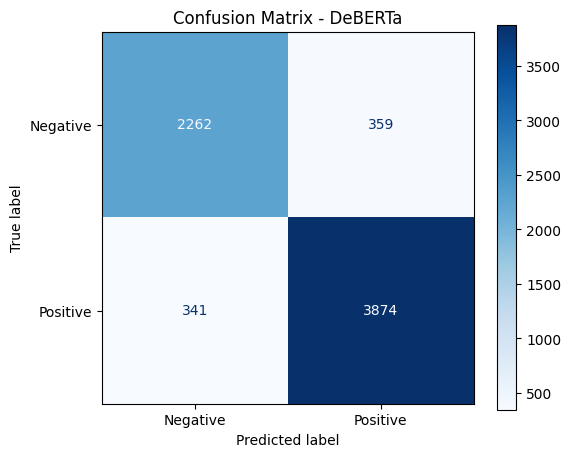

In [43]:
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - DeBERTa")
plt.grid(False)
plt.show()

In [44]:
report = classification_report(true_labels, preds, target_names=["Negative", "Positive"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display nicely
print("Classification Report (DeBERTa)")
display(df_report.round(3))

Classification Report (DeBERTa)


,precision,recall,f1-score,support
Negative,0.869,0.863,0.866,2621.000
Positive,0.915,0.919,0.917,4215.000
accuracy,0.898,0.898,0.898,0.898
macro avg,0.892,0.891,0.892,6836.000
weighted avg,0.897,0.898,0.898,6836.000


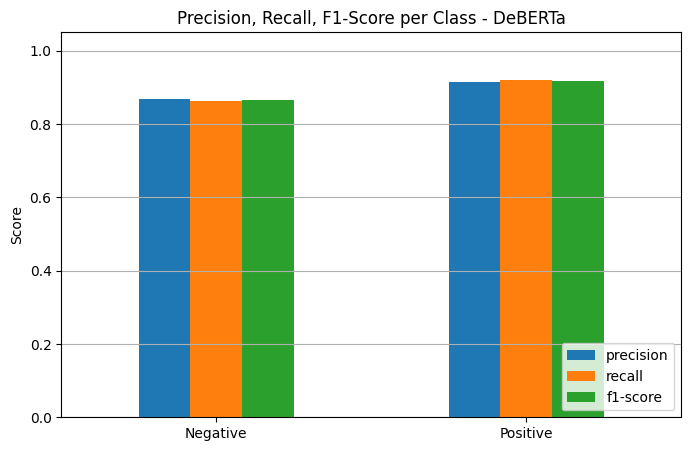

In [45]:
labels = ["Negative", "Positive"]
scores = ['precision', 'recall', 'f1-score']

# Extract scores for each label
data = {score: [report[label][score] for label in labels] for score in scores}
df_scores = pd.DataFrame(data, index=labels)

# Plot
df_scores.plot(kind='bar', figsize=(8, 5))
plt.title("Precision, Recall, F1-Score per Class - DeBERTa")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

In [56]:
!ls -l

total 82076
drwxr-xr-x 9 root root     4096 Apr 14 16:12  deberta-results
-rw-r--r-- 1 root root 30629915 Apr 14 16:27  drug_reviews_with_sentiment.csv
-rw-r--r-- 1 root root 26698164 Apr 14 15:58 'drug_review_test (1).csv'
-rw-r--r-- 1 root root 26698164 Apr 14 15:50  drug_review_test.csv
drwxr-xr-x 1 root root     4096 Apr 10 13:37  sample_data


In [50]:
tokenizer.save_pretrained("deberta-results")
model.save_pretrained("deberta-results")

In [52]:
# Load trained model
model_path = "./deberta-results"  # wherever you saved it
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [53]:
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=device)


Device set to use cuda:0


In [54]:
# Predict sentiment for all reviews in df
def predict_sentiment(review):
    try:
        output = sentiment_pipeline(review[:512])[0]['label']
        return 'Positive' if output == 'LABEL_1' else 'Negative'
    except:
        return 'Neutral'

df['predicted_sentiment'] = df['review'].apply(predict_sentiment)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [55]:
df.to_csv("drug_reviews_with_sentiment.csv", index=False)
print("✅ Saved CSV with predicted sentiments!")

✅ Saved CSV with predicted sentiments!
